Entrenar una red profunda no es fácil, pueden encontrarse muchos problemas:

- El gradiente puede crecer siempre, al ir hacia atrás en a través de la red.
- Tal vez no se tenga suficientes datos para una red tan grande, o sea muy costoso.
- El entrenamiento puede ser muy lento.
- Un modelo con millones de parámetros corre el riesgo de sobreajustar los datos de entrenamiento, sobretodo si hay pocas observaciones o mucho ruido.

## El problema de los gradientes explosivos

Los gradientes a menudo decrecen cuando el algoritmo progresa a las capas menores. Como resultado la actualización del descenso del gradiente deja los pesos de conexión sin cambio y el entrenamiento nunca converge a una solución. Esto es llamado **desvanecimiento de gradiente**. En algunos casos pasa lo contrario, los gradientes crecen y crecen hasta que las capas reciben pesos muy grandes y el algoritmo diverge, este el el problema de **gradientes explosivos**, esto pasa más seguido en RNN(**recurral neural networks**). Las redes profundas sufren de gradientes inestables, diferentes capas aprenden a velocidades diferentes.

Con la función **sigmoide** cuando los inputs se vuelven muy grandes (positivos o negativos) la función se satura en 0 o 1, con una derivada cercana a 0. Cuando se hace **backpropagation** no existe gradiente que propagar en la red, dejando casi nada para las capas más bajas.

## Inicialización de Gorot y He

Proponen una forma de aliviar significativamente el problema de los gradientes inestables. Mencionan que necesitamos que la señal fluya correctamente en ambas direcciones: hacia adelante con predicciones y hacia atrás con backpropagation. Para que esto suceda mencionan que necesitamos que los gradientes tengan igual varianza antes y después de fluir a través de una capa hacia atrás. 

Esto no se puede asegurar a menos que la capa tenga igual numero de inputs y outputs (**fan-in y fan-out de la capa**). Glorot y Bengio propusieron que: los pesos de conexión de cada capa debe ser inicializado al azar con la siguiente ecuación:

\begin{equation}
\text{Normal distribution with mean 0 and variance} \hspace{0.1cm} \sigma^2 = \frac{1}{fan_{avg}}
\end{equation}
Ó
\begin{equation}
\text{Distribución uniforme entre -r y +r, con } \hspace{0.1cm} r = \sqrt{\frac{3}{fan_{avg}}}
\end{equation}

donde $fan_{avg} = (fan_{in} + fan_{out}) / 2$. Esta estrategia se llama **Xavier initialization** o **Glorot initilization**.

Se tienen distintas opciones para las distintas funciones de activación:

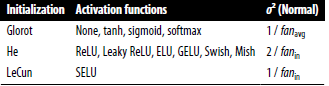

Por defecto, Keras utiliza la inicialización de Glorot con una distribución uniforme. Se puede cambiar estableciendo `kernel_initializer = 'her_uniform'` o `kernel_initializer = 'he_normal'` así:

In [11]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

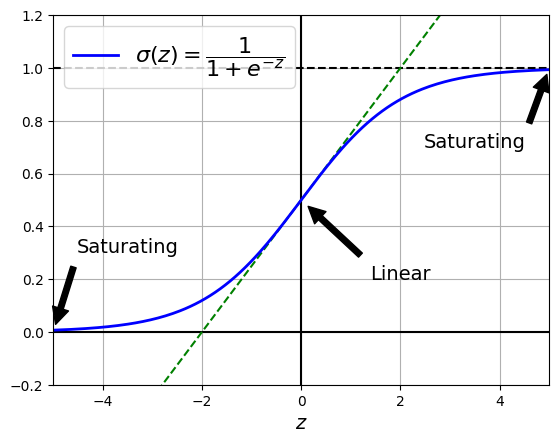

In [12]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

In [1]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation = 'relu',
                             kernel_initializer = 'he_normal')

También se pueden tener las inicializaciones de la tabla anterior usando `VarianceScaling`. por ejemplo, si se quiere la inicialización He con una distribución uniforme, basada en $fan_{avg}$

In [2]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale = 2, mode = 'fan_avg',
                                                   distribution = 'uniform')
dense = tf.keras.layers.Dense(50, activation = 'sigmoid',
                             kernel_initializer = he_avg_init)

## Mejores funciones de activación

Glorot y Bengio explican que el problema con los gradientes inestables se da en parte por la mala decisión de la función de activación.

La función ReLU a pesar de ser buena tiene un problema, **dying ReLUs:** durante el entrenamiento, algunas neuronas pueden **morir**, lo que quiere decir que dejan de dar salidas diferentes a 0. Esto pasa cuando sus pesos se cambian de forma que la entrada del la función ReLU es negativa para todas las observaciones del entrenamiento. Si esto pasa, se van a entregar solo 0s y el descenso de gradiente no afectará más ya que el gradiente de ReLU es cero cuando la entrada es negativa.

Para solucionar esto usamos una variante de ReLU.

### Leaky ReLU

Es definida como $\text{LeakyReLU)}_{\alpha}(z) = \max{\alpha z, z)}$

El hiperparámetro $\alpha$ define cuanto la función **leaks**: Es la pendiente de la función para z < 0. Esto nos asegura que Leaky ReLU nunca muera, pueden entrar en coma, pero tienen el chance de despertar. Según estudios Leaky ReLU siempre sobrepasa en rendimiento a la ReLU.

Estableciendo $\alpha = 0.2$ (un leak grande) rinde mejor que $\alpha = 0.01$ (pequeño leak). También se evalúa el **randomized leaky ReLU RReLU)**, $\alpha$ se escoge aleatoriamente en una rango durante entrenamientoy se establece una media para la evaluación, esto hace la parte de regularización en el modelo. Otro es el **Parametric leaky ReLU (PReLU)** donde $\alpha$ puede ser aprendido durante el entrenamiento, en vez de ser un hiperparámetro puede ser ajustado en el backpropagation como cualquier parámetro. PReLU tuvo mucho mejor rendimiento en conjuntos grandes de imágenes, pero en conjuntos pequeños corre el riesgo de sobreajustar el conjunto de entrenamiento.


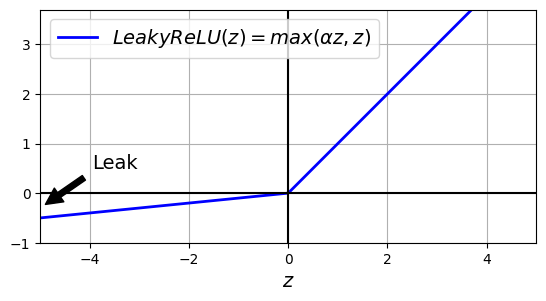

In [13]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [3]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2) # defecto alpha 0.3
dense = tf.keras.layers.Dense(50, activation = leaky_relu,
                             kernel_initializer = 'he_normal')

In [9]:
# o se puede en el modelo

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"), # sin activación
    tf.keras.layers.LeakyReLU(alpha=0.2) # la activación en una capa separada
])

ReLU, Leaky ReLU y PReLU sufren de que no son funciones suaves, sus derivadas cambian fuertemente (en z = 0). Esta discontinuidad puede hacer que el descenso de gradiente rebote alrededor del óptimo y la convergencia sea lenta. Ahora se verán variantes suavizadas de ReLU.

## ELU y SELU

**Exponential linear unit** rindió mejor que todas las variantes de ReLU para el autor, es la siguiente función:

\begin{equation}

\end{equation}